## Ridge regression implementation, with cross-validation

In [263]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt 
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error
import seaborn as sns

In [264]:
dataset = pd.read_csv("body_fat_data.csv", index_col=0)

In [265]:
features = ['Neck circumference (cm)','Chest circumference (cm)','Abdomen circumference (cm)', 'Hip circumference (cm)',
        'Thigh circumference (cm)', 'Knee circumference (cm)', 'Ankle circumference (cm)',
        'Extended biceps circumference (cm)', 'Forearm circumference (cm)', 
            'Wrist circumference (cm)','Age', 'Weight (lbs)','Fat Free Weight (1 - fraction of body fat) * Weight, using Brozek formula (lbs)',
            'Height (inches)',
           'Adiposity index = Weight/Height^2 (kg/m^2)']
features_short = ['Neck','Chest','Abdomen', 'Hip',
        'Thigh', 'Knee', 'Ankle ',
        'Extended biceps', 'Forearm', 
            'Wrist', 'Age', 'Weight (lbs)',
            'Height (inches)', 'Fat free Weight',
                 'Adiposity index']
target = 'Percent body fat using Siri equation 495/Density'

In [266]:
dataset.describe()

,Percent body fat using Siri equation 495/Density,Density gm/cm^3,Age,Weight (lbs),Height (inches),Adiposity index = Weight/Height^2 (kg/m^2),"Fat Free Weight (1 - fraction of body fat) * Weight, using Brozek formula (lbs)",Neck circumference (cm),Chest circumference (cm),Abdomen circumference (cm),Hip circumference (cm),Thigh circumference (cm),Knee circumference (cm),Ankle circumference (cm),Extended biceps circumference (cm),Forearm circumference (cm),Wrist circumference (cm)
count,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000,252.000000
mean,19.150794,1.055574,44.884921,178.924405,70.148810,25.436905,143.713889,37.992063,100.824206,92.555952,99.904762,59.405952,38.590476,23.102381,32.273413,28.663889,18.229762
std,8.368740,0.019031,12.602040,29.389160,3.662856,3.648111,18.231642,2.430913,8.430476,10.783077,7.164058,5.249952,2.411805,1.694893,3.021274,2.020691,0.933585
min,0.000000,0.995000,22.000000,118.500000,29.500000,18.100000,105.900000,31.100000,79.300000,69.400000,85.000000,47.200000,33.000000,19.100000,24.800000,21.000000,15.800000
25%,12.475000,1.041400,35.750000,159.000000,68.250000,23.100000,131.350000,36.400000,94.350000,84.575000,95.500000,56.000000,36.975000,22.000000,30.200000,27.300000,17.600000
50%,19.200000,1.054900,43.000000,176.500000,70.000000,25.050000,141.550000,38.000000,99.650000,90.950000,99.300000,59.000000,38.500000,22.800000,32.050000,28.700000,18.300000
75%,25.300000,1.070400,54.000000,197.000000,72.250000,27.325000,153.875000,39.425000,105.375000,99.325000,103.525000,62.350000,39.925000,24.000000,34.325000,30.000000,18.800000
max,47.500000,1.108900,81.000000,363.150000,77.750000,48.900000,240.500000,51.200000,136.200000,148.100000,147.700000,87.300000,49.100000,33.900000,45.000000,34.900000,21.400000


# Train and test split

In [251]:
train, test = train_test_split(dataset, test_size=0.33, random_state=1)

train_x = train[features].copy()
train_y = train[[target]].copy()

test_x = test[features].copy()
test_y = test[[target]].copy()

### Function to fit the model, using the ridge solution, with standardization

In [252]:
def ridge_fit(train, features, target, alpha):
    X = train[features].copy()
    y = train[[target]].copy()
    
    x_mean = X.mean()
    x_std = X.std()
    
    X = (X - x_mean) / x_std
    X["intercept"] = 1
    X = X[["intercept"] + features]
    
    penalty = alpha * np.identity(X.shape[1])
    penalty[0][0] = 0
    
    indices = ["intercept"] + features
    ridge = np.linalg.inv(X.T @ X + penalty) @ X.T @ y
    ridge.index = indices
    return ridge, x_mean, x_std

### Predicting using the model computed above. Using the mean and std of the training data to standardize the test data

In [253]:
def ridge_predict(test, predictors, x_mean, x_std, ridge):
    test_X = test[predictors]
    test_X = (test_X - x_mean) / x_std
    test_X["intercept"] = 1
    test_X = test_X[["intercept"] + predictors]

    predictions = test_X @ ridge
    return predictions

### K-fold validation, implemented using the general procedure described in https://machinelearningmastery.com/k-fold-cross-validation/

In [254]:
def k_fold_val(data, lambdas, partitions, repeats, features, target):
    cv = data[:int(data.shape[1] / partitions * 100 / data.shape[1])]
    train = data[int(data.shape[1] / partitions * 100 / data.shape[1]):]
    loss = {}
    for l in lmbdas:
        
        for n in range(repeats):
            partition_loss = []
            
            for split in range(1,partitions + 1):
                partition = train[(partitions * split) - partitions: partitions * split]
                
                ridge, x_mean, x_std = ridge_fit(partition, features, target, l)
                pred = ridge_predict(cv, features, x_mean, x_std, ridge)
                
                partition_loss.append(mean_absolute_error(cv[target], pred.values))
            
            loss[l] = np.mean(partition_loss)

            
    return min(loss, key = loss.get), loss

### Finding optimal lambda, and ploting the $\lambda$ loss. Because we're just plotting the loss without specifying the x, matplotlib is taking the length of the list to create the x. It sometimes displays the line with a small offset, which makes it look like it's not finding the optimal $\lambda$ 

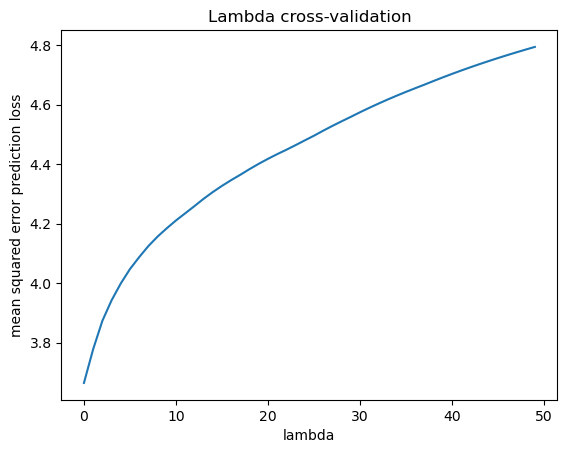

In [269]:
lmbdas = [i/2 for i in range(1,51)]
lmbda, loss = k_fold_val(train, lmbdas, 10, 1, features, target)
plt.plot(loss.values())
plt.xlabel("lambda")
plt.ylabel("mean squared error prediction loss")
plt.title("Lambda cross-validation")
plt.show()

### Calling ridge fit and predict

In [256]:
ridge, x_mean, x_std = ridge_fit(train, features, target, 0.5)
pred = ridge_predict(test, features, x_mean, x_std, ridge)

### Ridge coefficients

In [257]:
ridge

,Percent body fat using Siri equation 495/Density
intercept,18.994048
Neck circumference (cm),0.126276
Chest circumference (cm),0.765821
Abdomen circumference (cm),1.443411
Hip circumference (cm),0.832989
Thigh circumference (cm),0.655719
Knee circumference (cm),0.063546
Ankle circumference (cm),0.104089
Extended biceps circumference (cm),0.136410
Forearm circumference (cm),0.332313


In [258]:
err = mean_absolute_error(test[target], pred)

err

1.299234591611657

<AxesSubplot:>

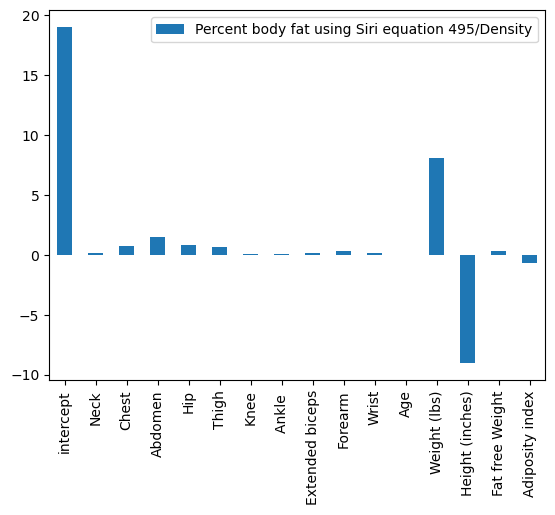

In [259]:
ridge.index= ["intercept"] + features_short
ridge.plot.bar()

### Intercept of the slope, which represents mean value of y when all the features are 0 

In [260]:
ridge.T['intercept'][0]

18.99404761904759

### Show first five errors

In [261]:
dif = 10
cnt=0
for i,val in enumerate(pred.values):
    if (test_y.iloc[i].values[0] - val > dif):
        cnt+=1
        print("Expected: " + str(test_y.iloc[i].values[0]) + " Actual: " + str(val[0]) + "  sample index: " + str(i))
        
cnt

0

### Model evaluation. This implementation has a better slope than the sklearn because it also uses fat free weight

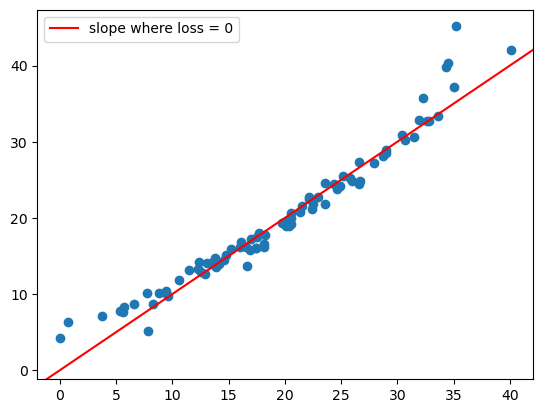

In [262]:
f, ax = plt.subplots(1)

ax.axline((1, 1), slope=1, c = 'red', label='slope where loss = 0')
plt.legend()
plt.scatter(test_y, pred)
plt.show()